***circle_packing.ipynb***

Place $N$ disjoint circles in the unit square to maximize the sum of their radii.

&copy; Copyright 2025 Fair Isaac Corporation

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0.
 
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This example uses FICO&reg; Xpress software. By running it, you agree to the Community License terms of the [Xpress Shrinkwrap License Agreement](https://community.fico.com/s/contentdocument/06980000002h0i5AAA) with respect to the FICO&reg; Xpress software. See the [licensing options](https://www.fico.com/en/fico-xpress-trial-and-licensing-options) overview for additional details and information about obtaining a paid license.

In [ ]:
# Install the xpress package
%pip install -q xpress

## Problem description and formulation

In this example, we aim at packing $N$ circles inside the unit square to maximize the sum of their radii. The circles must not overlap with each other and must be fully contained inside the unit square. Let $CIRCLES$ be the set $\{1,...,N\}$.

The continuous decision variables $x_i$ and $y_i$ represent the vector of $(x,y)$ coordinates of the center point of each circle $i \in CIRCLES$, and variables $r_i$ the corresponding radius.

The goal is to maximize the area inside the unit square occupied by circles, that is, the sum of the radii of all circles:

$$\max \sum_{i \in CIRCLES} r_{i}$$

The circles must not overlap, that is, the Euclidean distance between the center of any two circles must not be shorter than the sum of their radii. This can be represented by the following set of quadratic constraints:

$$ (x_i - x_j)^2 + (y_i - y_j)^2  \geq (r_i + r_j)^2, \qquad \forall i \in CIRCLES, \forall j \in i+1,...,N$$

Moreover, we need each circle to be fully contained within the unit square. Therefore, both the $x_i$ and $y_i$ coordinates of each circle must not be lower than its radius (similarly, they must not be greater than (1 - $r_i$)). This can be represented by the following linking constraints:

$$  
\begin{array}{llll}
& \qquad  x_i \geq r_i, \qquad \forall i \in CIRCLES \\
& \qquad  x_i \leq 1 - r_i, \qquad \forall i \in CIRCLES \\
& \qquad  y_i \geq r_i, \qquad \forall i \in CIRCLES \\
& \qquad  y_i \leq 1 - r_i, \qquad \forall i \in CIRCLES \\
\end{array}
$$

Additionally, the radius of each circle has a trivial upper bound equal to 0.5, since the diameter of any circle can never be greater than 1:

$$0 \leq r_i \leq 0.5, \qquad \forall i \in 1..N $$


## Model implementation

The previous model is implemented below. Note that the upper bound is defined on variable creation with [p.addVariables](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/python/HTML/problem.addVariables.html), which creates a *NumPy* array of $N$ variables when an integer is passed as the first argument.

In [1]:
import xpress as xp
import matplotlib.pyplot as plt

N = 6   # Number of circles to place.
CIRCLES = range(N)

# Create a problem instance.
p = xp.problem()

# Decision variables.
x = p.addVariables(N, name="x")         # x-coordinate of center points.
y = p.addVariables(N, name="y")         # y-coordinate of center points.
r = p.addVariables(N, name="r", ub=0.5) # Radii of circles, upper bound is 0.5 to fit in unit square.

# Non-overlap constraints.
p.addConstraint((x[i] - x[j])**2 + (y[i] - y[j])**2 >= (r[i] + r[j])**2 for i in CIRCLES for j in range(i + 1, N))

# Ensure that each circle is contained in the unit square.
p.addConstraint(x[i] >= r[i] for i in CIRCLES)
p.addConstraint(x[i] <= 1 - r[i] for i in CIRCLES)
p.addConstraint(y[i] >= r[i] for i in CIRCLES)
p.addConstraint(y[i] <= 1 - r[i] for i in CIRCLES)

# Objective function.
p.setObjective(xp.Sum(r), sense=xp.maximize)

Before triggering the optimization, a number of optimizer controls are set. For exact arithmetic, <!--we set the tolerance for matrix coefficients to zero via [MATRIXTOL](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/HTML/MATRIXTOL.html), and --> the feasibility tolerance is lowered to a very small value with [FEASTOL](https://www.fico.com/fico-xpress-optimization/docs/latest/solver/optimizer/HTML/FEASTOL.html). 

Moreover, we set a time limit of 3 seconds before defining the global solver (default) to solve the problem.

The code below defines these control parameters and optimizes the problem before printing the solution and objective values.

In [ ]:
# Control parameters.
p.controls.feastol = 1e-9               # Set the feasibility tolerance to a very small value.
p.controls.timelimit = 3                # Set a time limit in seconds.
#p.controls.worklimit = 0.6             # Alternatively, set a work limit instead of time as a deterministic stopping criterion.
p.controls.nlpsolver = xp.constants.NLPSOLVER_GLOBAL        # Set the NLP solver to global.

# Solve the problem.
p.optimize()

# Print a solution summary.
xsol = p.getSolution(x)
ysol = p.getSolution(y)
rsol = p.getSolution(r)
print(f"Sum of radii for N = {N} is {p.attributes.objval}")
for i in CIRCLES:
    print(f"{i}: x = {xsol[i]}, y = {ysol[i]}, r = {rsol[i]}")

## Visualization

The code cell below generates a plot of the circles defined by the solution inside the unit square, with a blue line and label indicating the radius of each circle.

N = 6, Sum of radii = 1.2028389108720672


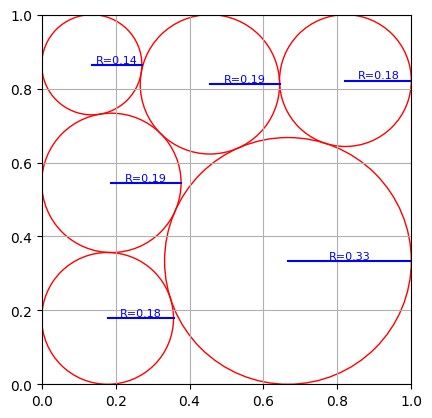

In [3]:
print(f"N = {N}, Sum of radii = {p.attributes.objval}")

# Create a plot
fig, ax = plt.subplots()

# Plot each circle
for (x, y, r) in zip(xsol, ysol, rsol):
    # Draw the circle with red edge
    circle = plt.Circle((x, y), r, edgecolor='red', facecolor='none')
    ax.add_patch(circle)

    # Draw the radius line in blue
    ax.plot([x, x + r], [y, y], color='blue')

    # Add the radius length as label
    ax.text(x + r / 2, y, f'R={r:.2f}', color='blue', fontsize=8, ha='center', va='bottom')

# Set the limits and aspect ratio
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal', 'box')
ax.grid(True)

# Show the plot
plt.show()